In [1]:
import torch
import math
import matplotlib.pyplot as plt
from plyfile import PlyData
import numpy as np

In [2]:
data = PlyData.read('bunny/reconstruction/bun_zipper_res3.ply')
points_gt = torch.stack([
    torch.from_numpy(data.elements[0][axis])
    for axis in ['x', 'y', 'z']
]).T.unsqueeze(-1)

points_gt = points_gt - points_gt.mean(dim=0)

In [3]:
torch.manual_seed(0)
theta = torch.rand(1) * math.pi / 2 #why divide by 2?
phi = torch.rand(1) * 2 * math.pi

camera_Rx = torch.tensor([
    [1,                0,                 0],
    [0, torch.cos(theta), -torch.sin(theta)],
    [0, torch.sin(theta),  torch.cos(theta)],
])
camera_Ry = torch.tensor([
    [ torch.cos(phi), 0, torch.sin(phi)],
    [              0, 1,              0],
    [-torch.sin(phi), 0, torch.cos(phi)],
])

camera_R = camera_Rx@camera_Ry
camera_t = torch.tensor([[0],[0],[0.2]])

In [4]:
camera_points = camera_R@points_gt + camera_t

In [5]:
def distort(beta1, beta2, points):
  x = points[:,0,:]
  y = points[:,1,:]

  r2 = x**2 + y**2
  r4 = r2**2

  distort_x = x*(1+ beta1*r2+beta2*r4)
  distort_y = y*(1+ beta1*r2+beta2*r4)
  
  return torch.stack([distort_x, distort_y],dim = 1)

In [6]:
camera_points.shape

torch.Size([1889, 3, 1])

In [7]:
perspective_projection = camera_points[:,:-1,:]/(camera_points[:,-1,:].unsqueeze(1))

#distortion


beta1 = 1.0
beta2 = 0.0

distort_xy  = distort(1.0, 0.0,  perspective_projection)
ones = torch.ones((distort_xy.shape[0],1,1))
distort_xyz = torch.cat([distort_xy,ones],dim = 1)

# w = 1 for all xy 

camera_K = torch.tensor([
    [1.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])


projected_points = (camera_K@distort_xyz)

#divide by w

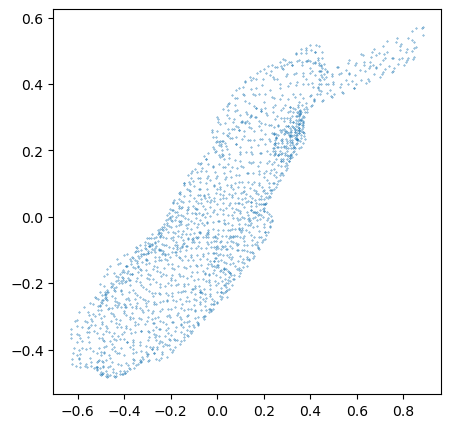

In [8]:
fig, axs = plt.subplots(1, figsize=(5, 5))

xpoints = projected_points[:,0].squeeze()
ypoints = projected_points[:,1].squeeze()
axs.scatter(xpoints,ypoints,s = 0.1)


In [9]:
# create 2 images with same intrinsic params but different extrinic params

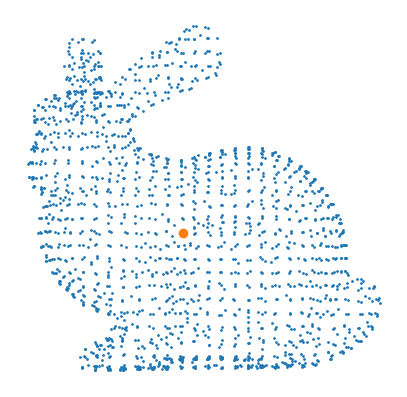

In [10]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.set_aspect(1.0)
ax.set_axis_off()
points_x, points_y, points_z = points_gt[:,:,:].squeeze().T
plt.scatter(points_x, points_y, s=1)
plt.scatter([0], [0])
plt.show()

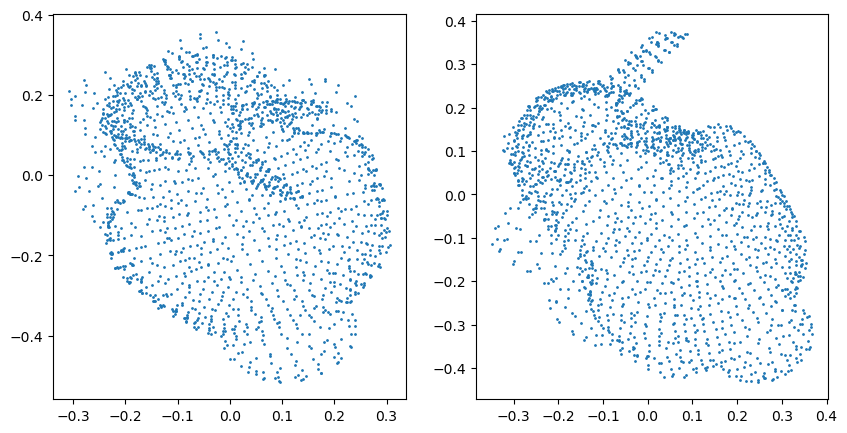

In [11]:
fig_2, axs = plt.subplots(1,2, figsize=(10, 5))

rotation_matrix = []
translation = []
points_list = []
depth = []
#same intrinsic params 
camera_K = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
]) 
torch.manual_seed(0)
x_temp = []
y_temp = []
x_camera = []
y_camera=[]
camera_point_list = []
camera_R_list = []
points = points_gt[:,:,:]
thetao = torch.rand(1) * math.pi / 2 #max 1/2 pi 
phio = torch.rand(1) * 2 * math.pi

for ax in axs.flatten():

  theta = thetao +np.random.random() #max 1/2 pi 
  phi =  phio+np.random.random()

  camera_Rx = torch.tensor([
      [1,                0,                 0],
      [0, torch.cos(theta), -torch.sin(theta)],
      [0, torch.sin(theta),  torch.cos(theta)],
  ])
  camera_Ry = torch.tensor([
      [ torch.cos(phi), 0, torch.sin(phi)],
      [              0, 1,              0],
      [-torch.sin(phi), 0, torch.cos(phi)],
  ])

  camera_R = camera_Rx@camera_Ry
#   print('camera_R')
  rotation_matrix.append(camera_R)
  camera_t = torch.tensor([[0],[0],[0.2]])
  translation = camera_t
  camera_points = camera_R@points + camera_t
  x_camera.append(camera_points[:,0,:])
  y_camera.append(camera_points[:,1,:])
  camera_R_list.append(camera_R)
  depth.append(camera_points[:,-1,:])
  # print(camera_points)
  camera_point_list.append(camera_points)
  perspective_projection = camera_points[:,:-1,:]/(camera_points[:,-1,:].unsqueeze(1))
  x_temp.append(perspective_projection[:,0])
  y_temp.append(perspective_projection[:,1])
  # print(perspective_projection[:,0])
  beta1 = 1.0
  beta2 = 0.0
  distort_xy  = distort(0.0, 0.0,  perspective_projection)
  ones = torch.ones((distort_xy.shape[0],1,1))
  distort_xyz = torch.cat([distort_xy,ones],dim = 1)
  # print(distort_xyz)

  projected_points = (camera_K@distort_xyz)
  # print(projected_points)
  xpoints = projected_points[:,0].squeeze()
  ypoints = projected_points[:,1].squeeze()
  ax.scatter(xpoints,ypoints,s = 1)

  points_list.append(projected_points)


In [12]:
#unprojection

In [13]:
point_distort_xyz_1 = torch.inverse(camera_K)@points_list[0]
point_distort_xyz_2 = torch.inverse(camera_K)@points_list[1]

In [17]:
points_list[0].shape

torch.Size([1889, 3, 1])

In [14]:
# point_distort_xyz_1 #all w = 1 

In [16]:
depth[0].shape

torch.Size([1889, 1])

In [16]:
from scipy.optimize import fsolve
def func(xy,beta1,beta2, distort_xy):
  
    x = xy[0:int(len(xy)/2)]
    y = xy[int(len(xy)/2):]
    r2 = np.array([x**2 + y**2,x**2 + y**2]).flatten()
    r4 = r2**2
  
    arr = []
    for i in range (len(xy)):
       arr.append(xy[i]*(1+ beta1*r2[i]+beta2*r4[i])-distort_xy[i])
     
    return arr


point_distort_x_1 = point_distort_xyz_1[:,0,:].squeeze().numpy()
point_distort_y_1 = point_distort_xyz_1[:,1,:].squeeze().numpy()
root_1 = fsolve(func, np.array([point_distort_x_1,point_distort_y_1]).flatten(), args = (1,0,np.array([point_distort_x_1,point_distort_y_1]).flatten()))
scaled_x_1 = root_1[:int(len(point_distort_x_1))]
scaled_y_1 = root_1[int(len(point_distort_y_1)):]
x_1 = scaled_x_1 *depth[0].squeeze().numpy()
y_1 = scaled_y_1 *depth[0].squeeze().numpy()


point_distort_x_2 = point_distort_xyz_2[:,0,:].squeeze().numpy()
point_distort_y_2 = point_distort_xyz_2[:,1,:].squeeze().numpy()
root_2 = fsolve(func, np.array([point_distort_x_2,point_distort_y_2]).flatten(), args = (1,0,np.array([point_distort_x_2,point_distort_y_2]).flatten()))
scaled_x_2 = root_2[:int(len(point_distort_x_2))]
scaled_y_2 = root_2[int(len(point_distort_y_2)):]
x_2 = scaled_x_2 *depth[1].squeeze().numpy()
y_2 = scaled_y_2 *depth[1].squeeze().numpy()


c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.18.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
reconsturcted_1 = torch.from_numpy(np.stack((x_1,y_1,depth[0].squeeze().numpy())).T).unsqueeze(2)
reconsturcted_2 = torch.from_numpy(np.stack((x_2,y_2,depth[1].squeeze().numpy())).T).unsqueeze(2)

In [18]:
False in (reconsturcted_2 - camera_point_list[1]<0.000001)

True

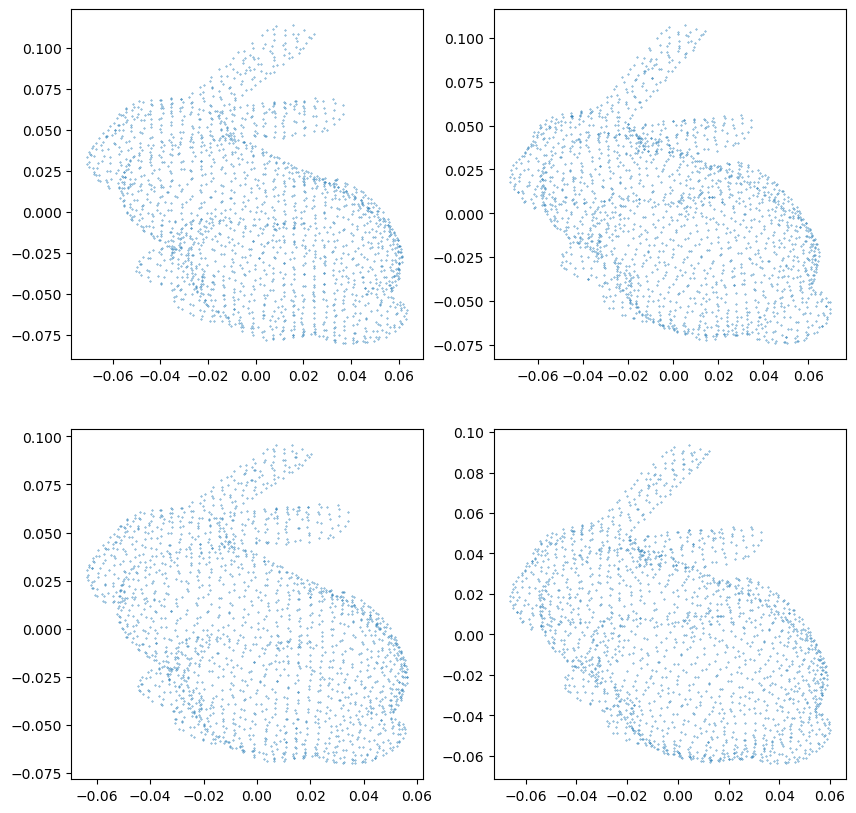

In [19]:
fig2,ax2 = plt.subplots(2,2,figsize = (10,10))
ax2[0,0].scatter(camera_point_list[0][:,0].squeeze().numpy(),camera_point_list[0][:,1].squeeze().numpy(),s = 0.1)
ax2[0,1].scatter(camera_point_list[1][:,0].squeeze().numpy(),camera_point_list[1][:,1].squeeze().numpy(), s= .1)
ax2[1,0].scatter(reconsturcted_1[:,0].squeeze().numpy(),reconsturcted_1[:,1].squeeze().numpy(),s = 0.1)
ax2[1,1].scatter(reconsturcted_2[:,0].squeeze().numpy(),reconsturcted_2[:,1].squeeze().numpy(),s=0.1)

In [20]:
np_recon_1 = reconsturcted_1.squeeze().numpy().T
np_recon_2 = reconsturcted_2.squeeze().numpy().T

In [21]:
np_recon_1.shape

(3, 1889)

1. find centroid of point1 and point2
2. bring point1 and point2 to origin and find Rotation mat
3. find translation t

http://nghiaho.com/?page_id=671

In [22]:
centroid1 = 1/len(np_recon_1) * np.sum(np_recon_1,axis = 1).T
centroid2 = 1/len(np_recon_2) * np.sum(np_recon_2,axis = 1).T

In [23]:
def rigid_transform_3D(A, B):

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [24]:
R,t = rigid_transform_3D(np_recon_1,np_recon_2)

In [25]:
t

array([[-0.01756513],
       [ 0.04945779],
       [ 0.00689583]])

In [26]:
translated_np_recon1 = ((R@np_recon_1)+t).T

In [27]:
np.where((translated_np_recon1- np_recon_2.T) > 0.01)

(array([], dtype=int64), array([], dtype=int64))

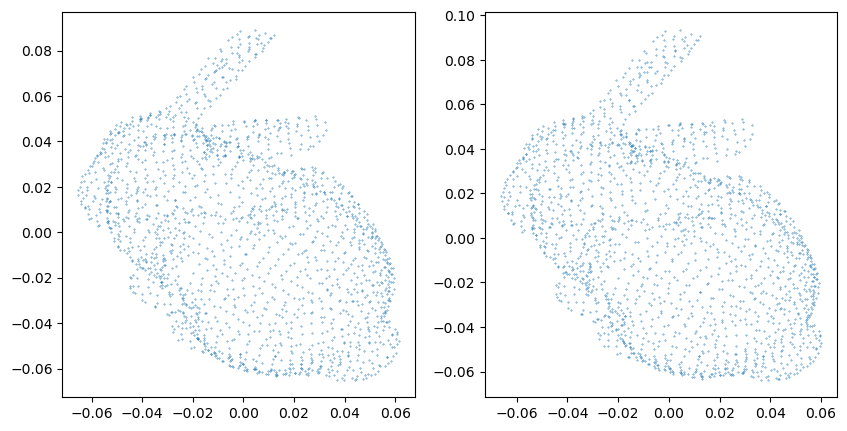

In [28]:
fig3,ax3 = plt.subplots(1,2,figsize = (10,5))
ax3[0].scatter(translated_np_recon1[:,0],translated_np_recon1[:,1],s = 0.1)
ax3[1].scatter(np_recon_2.T[:,0],np_recon_2.T[:,1], s= 0.1)
# ax2[1,0].scatter(reconsturcted_1[:,0].squeeze().numpy(),reconsturcted_1[:,1].squeeze().numpy(),s = 0.1)
# ax2[1,1].scatter(reconsturcted_2[:,0].squeeze().numpy(),reconsturcted_2[:,1].squeeze().numpy(),s=0.1)

In [29]:
p1 = camera_point_list[0].squeeze().numpy() #camera_point_list is the points in camera frame
p2 = camera_point_list[1].squeeze().numpy()
p14 = np.concatenate([p1,np.ones([len(p1),1])],axis = 1)
p24 = np.concatenate([p2,np.ones([len(p2),1])],axis = 1)


In [30]:
p1.shape

(1889, 3)

In [31]:
temptt = p24[:4,:]@(np.linalg.inv((p14[:4,:]).T))

In [32]:
(np.linalg.inv((p14[:4,:]).T))

array([[-380.68504876, -679.23349413, -606.91998054,  153.03333927],
       [ 372.52174836,  656.20827121,  546.15795315, -138.06956594],
       [ -55.18259515,  -66.35949987,  -47.9632754 ,   12.31160113],
       [  63.34589555,   89.38472279,  108.72530279,  -26.27537446]])

In [33]:
point_distort_xyz_2[:,:2,0].shape

torch.Size([1889, 2])

compute fundamental matrix with RANSAC

$x_{2}Fx_{1}$ = 0 

compute Essensial matrix M with F and intrinsic matrices 
$E = \Lambda^{T}_{2}F\Lambda_{1}$

In [34]:
#find fundamental matrix 

# [x2, y2, 1]F[x1,y1,1].T = 0 
#use opencv to find the fundamental matrix and do RANSAC matching
import cv2
F, mask = cv2.findFundamentalMat(points_list[0].numpy(),
                                 points_list[1].numpy(),
                                 cv2.FM_RANSAC)



In [35]:
F

array([[   9.9541089 , -115.83858285,   38.47968984],
       [ 162.62382963,  -12.06545694,   17.33477643],
       [ -39.31890152,  -13.05092488,    1.        ]])

In [36]:
F

array([[   9.9541089 , -115.83858285,   38.47968984],
       [ 162.62382963,  -12.06545694,   17.33477643],
       [ -39.31890152,  -13.05092488,    1.        ]])

In [37]:
E = (camera_K.T).numpy()@F@camera_K.numpy()
# np.linalg.det(E) = 0 True

In [38]:
E

array([[   9.9541089 , -115.83858285,   38.47968984],
       [ 162.62382963,  -12.06545694,   17.33477643],
       [ -39.31890152,  -13.05092488,    1.        ]])

Decompose essential matrix 

$E = \tau_{\times} \Omega$

singular decomposition

$E = ULV^{T} $

$\tau =ULWU^{T} $

$\Omega = UW^{-1}V^{T}$

where: 

$W = \begin{bmatrix}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{bmatrix}$

$\tau_{\times} = \begin{bmatrix}
0 & -\tau_{z} & \tau_{y}\\
\tau_{z} & 0 & -\tau_{x}\\
-\tau_{y} & \tau_{x} & 0
\end{bmatrix} 
$
equation 16.10

In [39]:
U,l,vh = np.linalg.svd(E, full_matrices=True, compute_uv=True, hermitian=False)

In [40]:
l.shape

(3,)

In [41]:
L = np.diag(l)

In [42]:
U@L@vh - E <0.0001 #correct sigular value decomposition 

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [43]:
W = np.matrix([[0,1,0],[-1,0,0],[0,0,1]])

In [44]:
tau = U@L@W@(U.T)

In [45]:
omega = U@np.linalg.inv(W)@(vh)

In [46]:
tau@omega - E < 0.0001 

matrix([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

In [47]:
tau

matrix([[ -11.21143569,  117.92936058,  -31.06956251],
        [-161.83778985,    9.31899907,  -24.78438462],
        [  38.94774763,   14.02833902,    1.89243662]])

In [48]:
x2 = points_list[1].squeeze().numpy()
x1 = points_list[1].squeeze().numpy()
x2.shape

(1889, 3)

In [52]:
p1 = camera_point_list[0].squeeze().numpy() #camera_point_list is the points in camera frame
p2 = camera_point_list[1].squeeze().numpy()

persp_p1 = p1[:,:2]/p1[:,[2]]
persp_p2 = p2[:,:2]/p2[:,[2]]

In [67]:
#xi2xi1
xi2xi1 = persp_p2[:,0]*persp_p1[:,0]
xi2yi1 = persp_p2[:,0]*persp_p1[:,1]
xi2 = persp_p2[:,0]
yi2xi1 = persp_p2[:,1]*persp_p1[:,0]
yi2yi1 = persp_p2[:,1]*persp_p1[:,1]
yi2 = persp_p2[:,1]
xi1 = persp_p1[:,0]
yi1 = persp_p1[:,1]
ones = np.ones([len(persp_p1)])

In [77]:
MatA = np.stack([xi2xi1,xi2yi1,xi2,yi2xi1,yi2yi1,yi2,xi1,yi1,ones],axis = 1)

In [81]:
MatA.shape

(1889, 9)

In [83]:
#eight point algorithm
def calc_F(A):

    _,_,v = np.linalg.svd(A)
    f_vec = v.transpose()[:,8]
    # print("f_vec = ", f_vec)
    f_hat = np.reshape(f_vec, (3,3))
    # print("Fmat = ", f_hat)

    # Enforce rank(F) = 2 
    s,v,d = np.linalg.svd(f_hat)
    f_hat = s @ np.diag([*v[:2], 0]) @ d

    return f_hat

In [93]:
MatF = calc_F(MatA)

In [94]:
MatF

array([[-4.72410307e-02,  7.80196101e-02,  6.63508102e-01],
       [ 7.80194102e-02,  4.72410696e-02,  2.26800000e-01],
       [-6.85042604e-01, -1.49659170e-01, -2.58320254e-10]])

In [95]:
F

array([[   9.9541089 , -115.83858285,   38.47968984],
       [ 162.62382963,  -12.06545694,   17.33477643],
       [ -39.31890152,  -13.05092488,    1.        ]])

In [96]:
MatE = (camera_K.T).numpy()@MatF@camera_K.numpy()

In [97]:
eight_U,eight_l,eight_vh = np.linalg.svd(MatE, full_matrices=True, compute_uv=True, hermitian=False)

In [98]:
eight_L = np.diag(eight_l)

In [99]:
eight_U@eight_L@eight_vh - MatE <0.0001 #correct sigular value decomposition 

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [106]:
eight_tau = eight_U@eight_L@W@(eight_U.T)

In [107]:
eight_omega = eight_U@np.linalg.inv(W)@(eight_vh)

In [108]:
eight_tau@eight_omega - MatE < 0.0001 

matrix([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

In [109]:
tau

matrix([[ -11.21143569,  117.92936058,  -31.06956251],
        [-161.83778985,    9.31899907,  -24.78438462],
        [  38.94774763,   14.02833902,    1.89243662]])

In [111]:
#back projection by using F
#using actual image

#lsd-slam 
#colemap 

